In [ ]:
import configparser
import snowflake.connector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pmdarima import auto_arima                        
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import statsmodels.api as sm
import warnings
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Connection

In [ ]:
#config_file = 'credentials.conf.txt'
config_file = 'credentials.conf'

In [ ]:
credentials = configparser.ConfigParser()
credentials.read(config_file)
connection = snowflake.connector.connect(**credentials['SNOWFLAKE_DEV_TASTY'])          
cursor = connection.cursor()
cursor.execute("USE DATABASE {database}".format(**credentials['SNOWFLAKE_DEV_TASTY']))
cursor.execute("USE SCHEMA {schema}".format(**credentials['SNOWFLAKE_DEV_TASTY']))

# Load Data

In [ ]:
sales = pd.read_sql('''
                       SELECT *
                       FROM SALES_HISTORY_04232020
                    ''', connection)

In [ ]:
sales.head()

,WEEKLY_SALES_DATE,PRODUCT_ID,STORE_ID,CATEGORY,SUB_CATEGORY,STORE_GROUP,SALES_TYPE_ID,SALES_PRICE,QUANTITY,REVENUE,PREDICTED_UNITS
0,2017-09-02,0001,01,03,361,1,1.0,5.68,13.0,73.84,18.85
1,2017-09-09,0001,01,03,361,1,1.0,5.68,16.0,90.88,29.17
2,2017-09-16,0001,01,03,361,1,1.0,5.68,21.0,119.28,30.66
3,2017-09-23,0001,01,03,361,1,1.0,5.68,20.0,113.60,30.84
4,2017-09-30,0001,01,03,361,1,1.0,5.68,25.0,142.00,23.50


In [ ]:
sales.groupby(["CATEGORY","SUB_CATEGORY"])["SUB_CATEGORY"].count().head()

CATEGORY  SUB_CATEGORY
01        033              1944
          034              1898
          035               612
          127             29292
          177             11475
Name: SUB_CATEGORY, dtype: int64

In [ ]:
#creating a copy for analysis
sales_copy = sales.copy()

# Sales of a given store, category, subcategory

In [ ]:
def data_prep(product_id):
    
        # For SALES_HISTORY for the given product IDs
        prod_details = sales_copy[(sales_copy["PRODUCT_ID"] == product_id)]
        prod_summ = prod_details.groupby("WEEKLY_SALES_DATE")["QUANTITY", "PREDICTED_UNITS"].sum()

        #creating a series of datetime indices to adjust for missing week dates
        #adding shift to move it by a day 'D' from Sunday to Saturday
        idx = pd.date_range(start = prod_details["WEEKLY_SALES_DATE"].min(), end = prod_details["WEEKLY_SALES_DATE"].max(),freq = "W").shift(-1, freq = 'D')
        
        #Change index type to Datetime
        prod_summ.index = prod_summ.index.astype("datetime64[ns]")

        # fill missing data with zero 
        prod_summ = prod_summ.reindex(idx, fill_value = 0) 
        return prod_summ


In [ ]:
prod_summ=data_prep("0026")
prod_summ.head()

,QUANTITY,PREDICTED_UNITS
2017-09-16,2.0,4.39
2017-09-23,8.0,15.53
2017-09-30,0.0,0.00
2017-10-07,2414.0,2020.74
2017-10-14,136.0,208.15


## Trend & Seasonality
#### This is a naive decomposition.The seasonal component is first removed by applying a convolution filter to the data. The average of this smoothed series for each period is the returned seasonal component.
#### The additive model is Y[t] = T[t] + S[t] + e[t]
#### The multiplicative model is Y[t] = T[t] * S[t] * e[t]

### Trend Decomposition for Product 0026

In [ ]:
def trend_decomp(prod_summ):
    signal = prod_summ['QUANTITY']

    #Additive by default
    decomposition = seasonal_decompose(signal)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    resid = decomposition.resid

    plt.figure(figsize=(16,6))
    plt.title('Additive Seasonality')
    plt.plot(signal, label='signal')
    plt.plot(trend, label='trend')
    plt.plot(seasonal, label='seasonal')
    plt.plot(resid, label='resid')
    plt.legend()

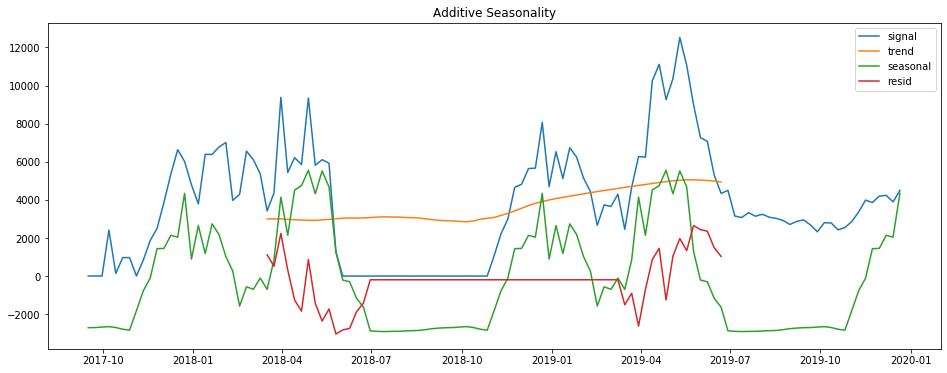

In [ ]:
trend_decomp(prod_summ)

## Visual Test for Stationarity 

In [ ]:
def roll_stats(prod_summ):
    # Calculate rolling statistics
    rolling_mean = prod_summ['QUANTITY'].rolling(window=8, center=False).mean()
    rolling_std = prod_summ['QUANTITY'].rolling(window=8, center=False).std()

    plt.figure(figsize=(16,6))
    plt.plot(prod_summ['QUANTITY'], label='signal')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling STD')
    plt.legend()

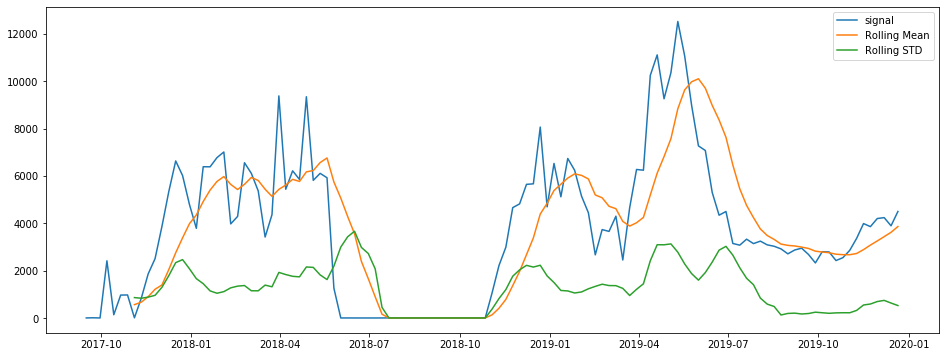

In [ ]:
roll_stats(prod_summ)

## Check for Stationarity

### Augmented Dickey-Fuller
Augmented Dickey-Fuller unit root test suggests d value in I(d). Specifically, if p-value of ADF test > 0.1, then time series is non stationary and we should take difference until the difference pass the stationary test. 

Null Hypothesis: The series has a unit root (not-stationary)

Alternate Hypothesis: The series has no unit root (stationary).

### KPSS
Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).


- Case 1: Both tests conclude that the series is not stationary -> series is not stationary
- Case 2: Both tests conclude that the series is stationary -> series is stationary
- Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
- Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

Sources: 

https://medium.com/analytics-vidhya/time-series-forecasting-sarima-vs-auto-arima-models-f95e76d71d8f

https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

In [ ]:
def stationary_test(prod_summ):
    X = prod_summ['QUANTITY'].values
    dftest = adfuller(X)
    dfoutput = pd.Series(dftest[:4], index=['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    kpss_test = kpss(prod_summ['QUANTITY'])
    kpss_output = pd.Series(kpss_test[:3], index=['ADF Test Statistic', 'p-value', '#Lags Used'])

    print('\n ADF Results')
    for key, val in dftest[4].items():
        dfoutput['Criticial Value (%s)' % key] = val
    print(dfoutput)
    if dfoutput['p-value'] < .05:
        print('The signal is stationary by ADF test')
    else:
        print('The signal is not stationary by ADF test')

    print('\n KPSS Results')
    for key, val in kpss_test[3].items():
        kpss_output['Criticial Value (%s)' % key] = val
    print(kpss_output)
    if kpss_output['p-value'] < .05:
        print('The signal is not stationary by KPSS test')
    else:
        print('The signal is stationary by KPSS test')
    print('\t')

In [ ]:
stationary_test(prod_summ)


 ADF Results
ADF Test Statistic              -2.801819
p-value                          0.058014
#Lags Used                       0.000000
Number of Observations Used    118.000000
Criticial Value (1%)            -3.487022
Criticial Value (5%)            -2.886363
Criticial Value (10%)           -2.580009
dtype: float64
The signal is not stationary by ADF test

 KPSS Results
ADF Test Statistic         0.123625
p-value                    0.100000
#Lags Used                13.000000
Criticial Value (10%)      0.347000
Criticial Value (5%)       0.463000
Criticial Value (2.5%)     0.574000
Criticial Value (1%)       0.739000
dtype: float64
The signal is stationary by KPSS test
	


C:\Users\shali\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

C:\Users\shali\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning:

p-value is greater than the indicated p-value



# Triple Exponential Smoothing

Exponential smoothing is a time series forecasting method for univariate data. Time series methods like the Box-Jenkins ARIMA family of methods develop a model where the prediction is a weighted linear sum of recent past observations or lags. Exponential smoothing forecasting methods are similar in that a prediction is a weighted sum of past observations, but the model explicitly uses an exponentially decreasing weight for past observations. Specifically, past observations are weighted with a geometrically decreasing ratio.

Source: https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/<br>
Simple Smoothing:forecasting method for univariate data without a trend or seasonality;<br>
$F_{t+1}$ = $\alpha D_{t}$ + $(1- \alpha)F_{t}$
- $F_{t+1}$ - forecast
- $D_{t}$ - Sales in time t
- $\alpha$ - smoothing constant

Holt's Method:forecasting method for univariate data with a trend but no seasonality;<br>
$F_{t+1}$ = $a_{t}$ + $b_{t}$= Level component + Slope component <br>
$a_{t}=\alpha D_{t} + (1-\alpha)(a_{t-1}+b_{t-1})=\alpha D_{t} + (1-\alpha)(F_{t-1})$<br>
$b_{t}=\beta(a_{t} - a_{t-1}) + (1-\beta)(b_{t-1})=\beta(level_{t} - level_{(t-1)}) + (1-\beta)(Slope_{t-1})$
- $F_{t+1}$ - forecast
- $D_{t}$ - Sales in time t
- $\alpha$ - smoothing constant for level
- $\beta$ - smoothing constant for trend

Winters Method:forecasting method for univariate data with a trend and seasonality;<br>
$F_{t+1}$ = $(a_{t}+ b_{t})*C_{t}$= (Level component + Slope component)\* Seasonality component<br>
$a_{t}=\alpha (D_{t}/C_{t}) + (1-\alpha)(a_{t-1}+b_{t-1})$<br>
$b_{t}=\beta(a_{t} - a_{t-1}) + (1-\beta)(b_{t-1})=\beta(level_{t} - level_{(t-1)}) + (1-\beta)(Slope_{t-1})$<br>
$C_{t}=\gamma (D_{t}/a_{t}) + (1-\gamma)*C_{t}$<br>
- $F_{t+1}$ - forecast
- $D_{t}$ - Sales in time t
- $\alpha$ - smoothing constant for level
- $\beta$ - smoothing constant for trend
- $\gamma$ - smoothing constant for trend


https://blog.arkieva.com/statistical-forecasting-damping-factors-what-if-wednesday/<br>
#### Damping Factor: 
Damping factor is an additional parameter that forecasting tools use to damp the forecast. This usually affects the trend of the forecast. Many a times we do not expect the sales to grow year over year with the same increasing (or decreasing) trend in which case we need to damp the forecast that was created using the historical trend. Its value can be set to any number between 0 and 1. The idea here is that when the damping factor is set to 0.9 the trend in the forecast will be reduced to 90% each future period.<br>
As we change the factor from 0.8 to 0.85 to 0.9 and so on we see an increase in the forecast as it follows the trend which is more in line with the history.<br>

https://machinelearningmastery.com/power-transform-time-series-forecast-data-python/<br>
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/<br>
https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html?highlight=statsmodels%20tsa%20holtwinters#id1



#### Box-Cox transform:
It is a configurable data transform method that supports both square root and log transform, as well as a suite of related transforms. lambda parameter set to None (the default) lets the function find a statistically tuned value

#### Seasonality Models
In the additive model, the behavior is linear where changes over time are consistently made by the same amount, like a linear trend. In this situation, the linear seasonality has the same amplitude and frequency.
Different from the additive model, the multiplicative model has an increasing or decreasing amplitude and/or frequency over time

## Triple Exponential Smoothing 
- Training: from 2017-09-02 to 2019-11-16
- Test: from 2019-11-23 until 2019-12-28

In [ ]:
prod_summ.tail()

,QUANTITY,PREDICTED_UNITS
2019-11-23,3858.0,2768.97
2019-11-30,4200.0,10932.35
2019-12-07,4238.0,9896.36
2019-12-14,3893.0,49129.37
2019-12-21,4497.0,42568.09


In [ ]:
len(prod_summ.loc['2019-11-17':'2019-12-21'])

5

In [ ]:
def TES(prod_summ):
    #Prepare Data for subcategory weekly sales
    prod_rev = pd.DataFrame(data=prod_summ['QUANTITY'], columns=['QUANTITY'])
    
    #creating a dataframe with predicted units
    pred_rev = pd.DataFrame(data=prod_summ['PREDICTED_UNITS'], columns=['QUANTITY'])
    
    #Splitting the dataset
    train_cnt=len(prod_summ.loc['2017-09-16':'2019-11-09'])
    train_data=prod_rev[:train_cnt]
    test_data=prod_rev[train_cnt:]
    
    fit = ExponentialSmoothing(train_data,seasonal_periods=52, seasonal='add').fit()

    #Forecast & fitted for fit
    plt.figure(figsize=(16,6))
    plt.title('Actual Sales Vs Engage3')
    plt.plot(prod_rev, color='k',marker='.',label = "Actual")
    plt.plot(pred_rev, color='g',marker='o',label='Engage3')
    plt.legend()
    plt.show()

    prod_rev.plot(label='Actual', marker='.',figsize=(16,6))
    fit.fittedvalues.plot(style='--', color='red',figsize=(16,6))
    fit.forecast(len(test_data)).plot(style='--', marker='o', color='red', label='TES',legend=True, figsize=(16,6))
    plt.title('Actual Sales Vs Triple Exponential Smoothing')
    plt.show()
    
    plt.figure(figsize=(16,6))
    plt.title('Overall Comparison')
    plt.plot(prod_rev, color='k',label = "Actual")
    plt.plot(pred_rev, color='g',label='Engage3')
    fit.fittedvalues.plot(style='--', color='red',label='fitted', figsize=(16,6))
    fit.forecast(len(test_data)).plot(style='--', marker='.', color='red', label='TES', figsize=(16,6))
    plt.legend()
    plt.show()
    pred=pd.DataFrame(fit.forecast(len(test_data)))
    result_data= test_data.copy()
    result_data['Predict']=pred
    result_data['E3']=pred_rev[train_cnt:]
    return result_data

In [ ]:
def trimmed_TES(prod_summ):
    #Prepare Data for subcategory weekly sales
    prod_rev = pd.DataFrame(data=prod_summ, columns=['QUANTITY'])
    
    #creating a dataframe with predicted units
    pred_rev = pd.DataFrame(data=prod_summ, columns=['PREDICTED_UNITS'])
    
    #Splitting the dataset
    train_cnt=len(prod_summ.loc['2017-09-16':'2019-11-09'])
    train_data=prod_rev[:train_cnt]
    test_data=prod_rev[train_cnt:]
    import warnings
    warnings.filterwarnings('ignore')
    fit = ExponentialSmoothing(train_data,seasonal_periods=52, seasonal='add').fit()
    pred=pd.DataFrame(fit.forecast(len(test_data)))
    result_data= test_data.copy()
    result_data['Predict']=pred
    result_data['E3']=pred_rev[train_cnt:]
    return result_data

In [ ]:
#Store forecasted values in a dataframe
predicted=trimmed_TES(prod_summ)

In [ ]:
pred_rev = pd.DataFrame(data=prod_summ['PREDICTED_UNITS'])

In [ ]:
predicted

,QUANTITY,Predict,E3
2019-11-16,3987.0,4121.934784,3536.12
2019-11-23,3858.0,5263.708785,2768.97
2019-11-30,4200.0,5653.813764,10932.35
2019-12-07,4238.0,6798.035825,9896.36
2019-12-14,3893.0,7551.278337,49129.37
2019-12-21,4497.0,9006.467283,42568.09


# Evaluation Metric

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
def measure_rmse(predict_df):
    #print('Evaluation for TES')
    rmse=sqrt(mean_squared_error(predict_df['QUANTITY'], predict_df['Predict']))
    #print('RMSE',rmse)
    r2_score_trial=r2_score(predict_df['QUANTITY'], predict_df['Predict'])
    #print('r2_score',r2_score_trial)
    #print('\nEvaluation for E3 Model')
    rmse_e3=sqrt(mean_squared_error(predict_df['QUANTITY'], predict_df['E3']))
    #print('RMSE',rmse_e3)
    r2_score_e3=r2_score(predict_df['QUANTITY'], predict_df['E3'])
    #print('r2_score',r2_score_e3)
    results = pd.DataFrame()
    results = results.append({'rmse_trial': rmse, 'r2_score_trial': r2_score_trial, 'rmse_e3': rmse_e3, 'r2_score_e3':r2_score_e3}, ignore_index=True)
    
    return results



In [ ]:
measure_rmse(predicted)

,r2_score_e3,r2_score_trial,rmse_e3,rmse_trial
0,-11916.005018,-146.959148,24407.880961,2719.677617


In [ ]:
measure_rmse(predicted)

,r2_score_e3,r2_score_trial,rmse_e3,rmse_trial
0,-11916.005018,-146.959148,24407.880961,2719.677617



	 0026 	

 ADF Results
ADF Test Statistic              -2.801819
p-value                          0.058014
#Lags Used                       0.000000
Number of Observations Used    118.000000
Criticial Value (1%)            -3.487022
Criticial Value (5%)            -2.886363
Criticial Value (10%)           -2.580009
dtype: float64
The signal is not stationary by ADF test

 KPSS Results
ADF Test Statistic         0.123625
p-value                    0.100000
#Lags Used                13.000000
Criticial Value (10%)      0.347000
Criticial Value (5%)       0.463000
Criticial Value (2.5%)     0.574000
Criticial Value (1%)       0.739000
dtype: float64
The signal is stationary by KPSS test
	

	 0099 	

 ADF Results
ADF Test Statistic              -3.382540
p-value                          0.011569
#Lags Used                       0.000000
Number of Observations Used    120.000000
Criticial Value (1%)            -3.486056
Criticial Value (5%)            -2.885943
Criticial Value (10%)       

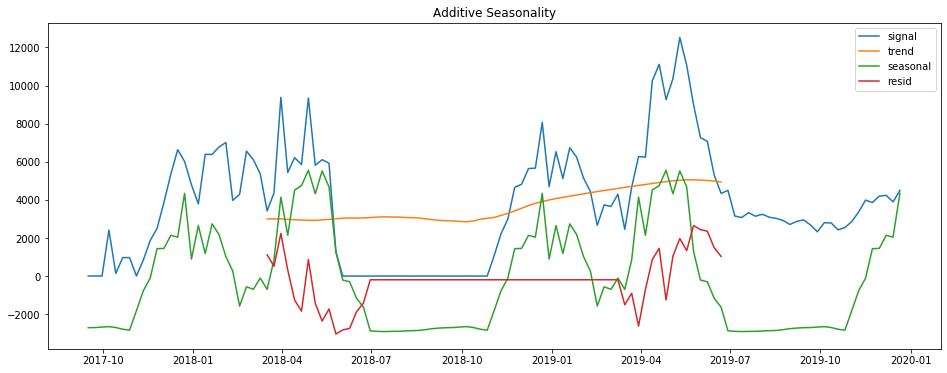

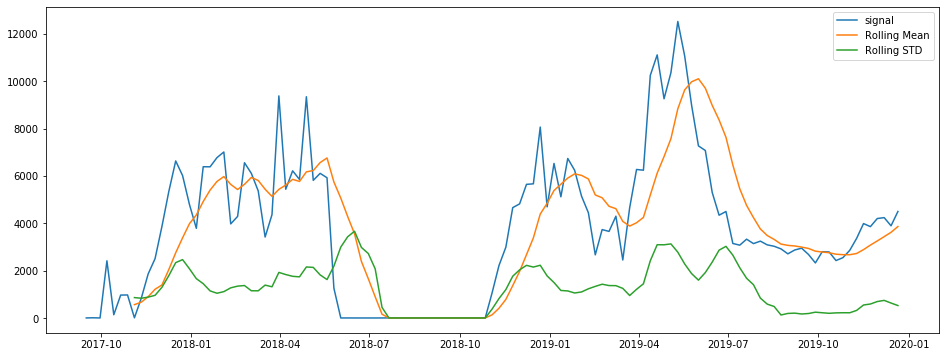

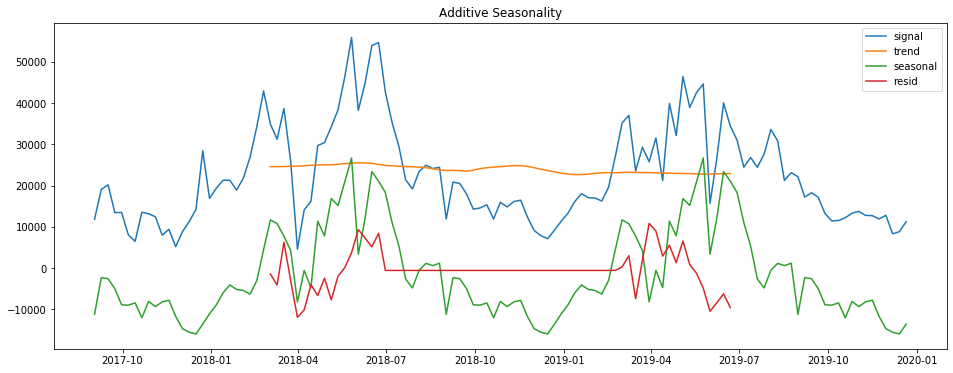

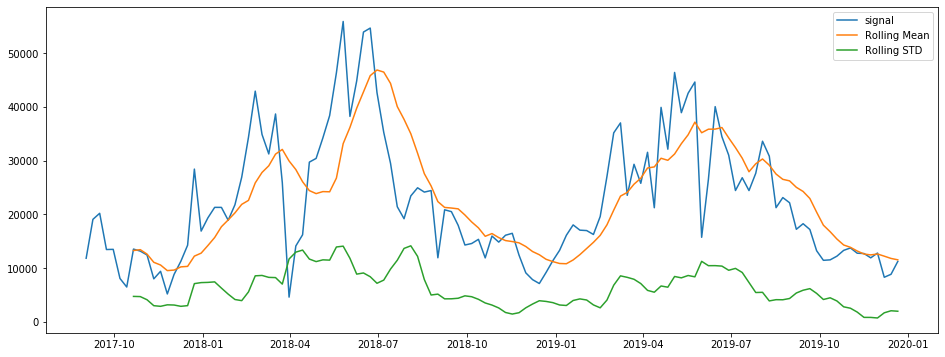

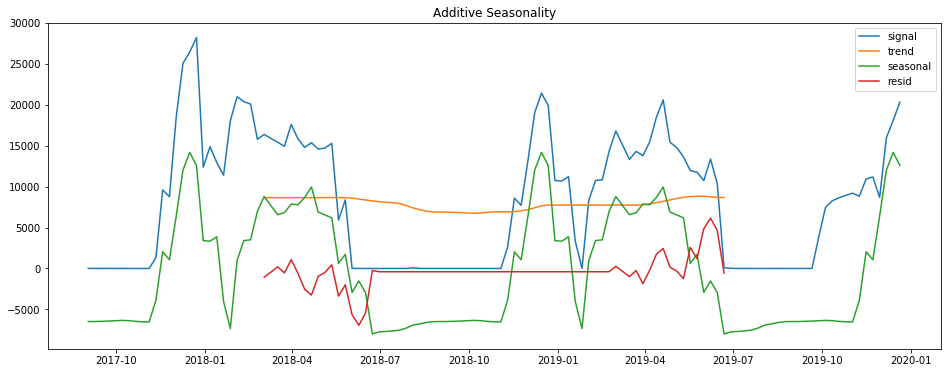

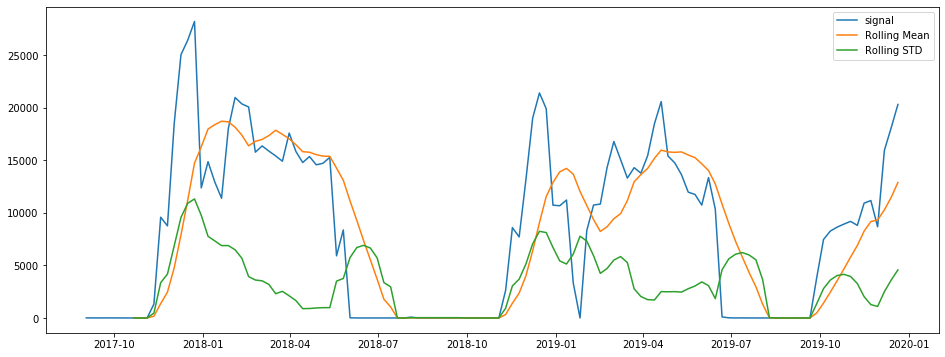

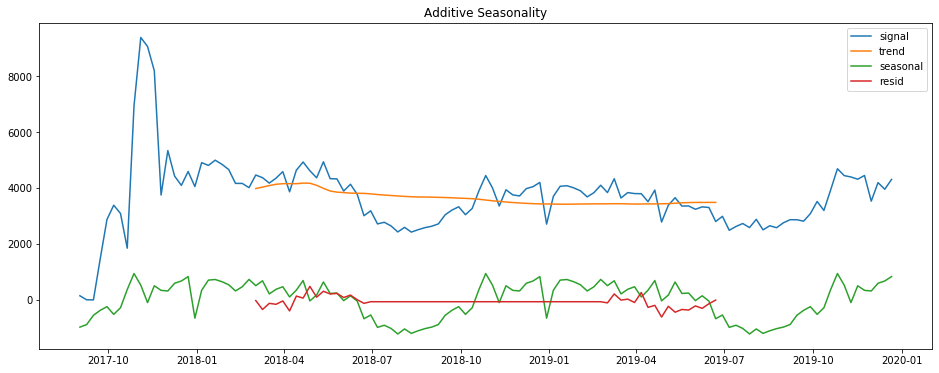

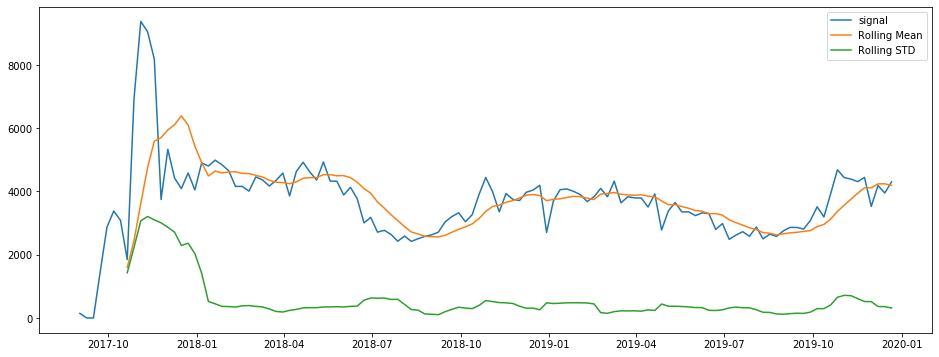

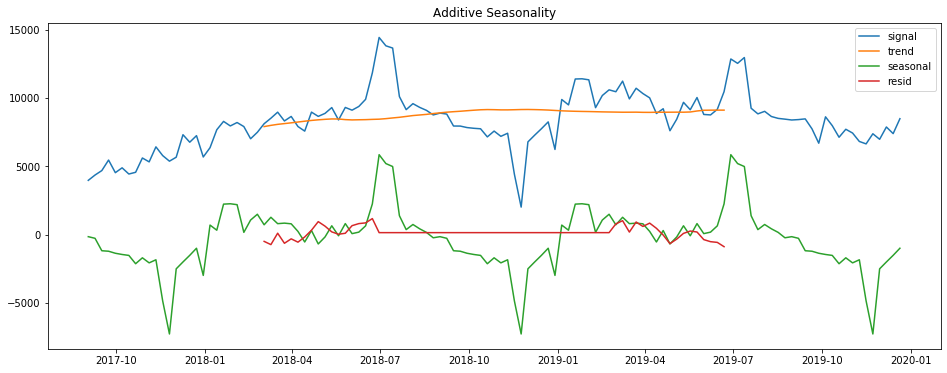

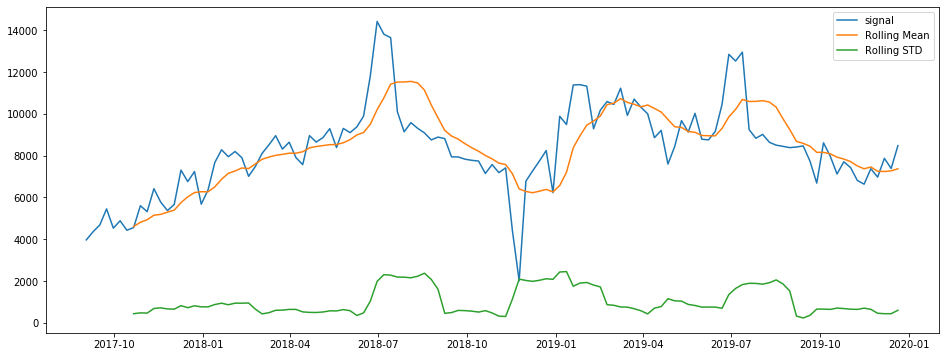

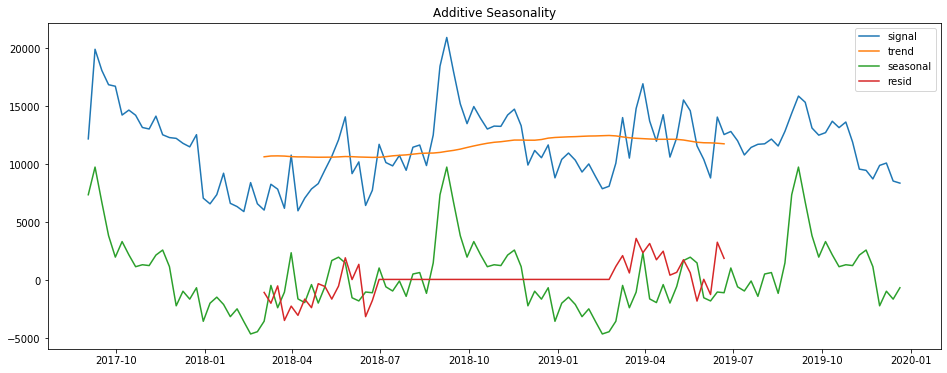

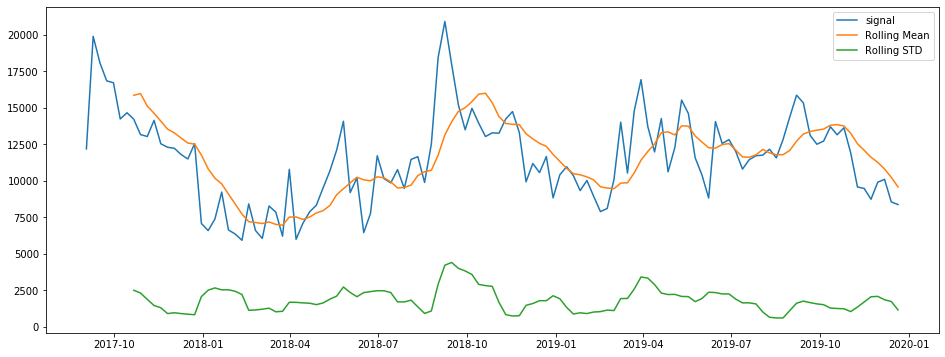

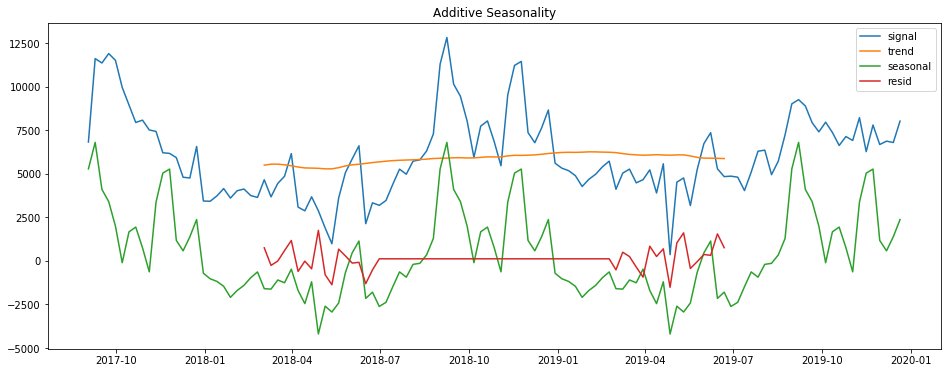

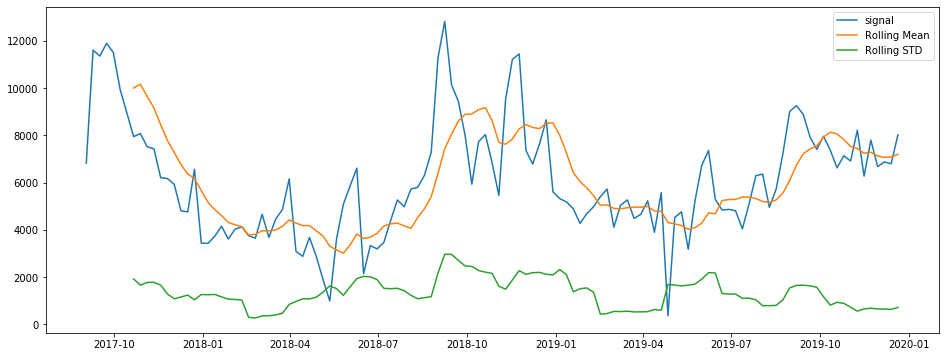

In [ ]:
prod_range=['0026','0099','0524','0584','0955','1137','1138']
results=pd.DataFrame()
for prod_id in prod_range:
    print('\n\t',prod_id,'\t')
    #Data Pre-processing
    prod_summ=data_prep(prod_id)
    #Trend Decomposition
    trend_decomp(prod_summ)
    #Visual check for Stationarity
    roll_stats(prod_summ)
    #Statistical Tests for stationarity
    stationary_test(prod_summ)
    #Predicted Values, store results dataframe
    predicted=trimmed_TES(prod_summ)
    #results['prod_id']=prod_id
    #Evaluation metrics for comparison across models
    results=results.append(measure_rmse(predicted),prod_id)